## IMPORT ALL THE LIBRARIES

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import pickle
import re
import glob
from pycocotools.coco import COCO
from transformers import CLIPProcessor, CLIPModel
import warnings
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import textwrap
from PIL import Image
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')

## LOAD THE DATA

In [30]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Constants and paths
SUBJ = "subj04"
TRAINING_PATH = f"{SUBJ}/training_split"
IMAGES_PATH = f"{TRAINING_PATH}/training_images"
FMRI_PATH = f"{TRAINING_PATH}/training_fmri"
LH_FMRI_PATH = os.path.join(FMRI_PATH, "lh_training_fmri.npy")
RH_FMRI_PATH = os.path.join(FMRI_PATH, "rh_training_fmri.npy")
STIM_INFO_PATH = "nsd_stim_info_merged.csv"

## LOAD CLIP MODEL FOR EMBEDDING EXTRACTION

In [31]:
# Load the CLIP model for multimodal embeddings
print("Loading CLIP model for multimodal embeddings...")
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = clip_model.to(device)

Loading CLIP model for multimodal embeddings...


## HELPER FUNCTIONS

In [32]:
def load_mapping_info():
    """
    Load and preprocess the mapping information for the NSD dataset.
    """
    stim_info = pd.read_csv(STIM_INFO_PATH, index_col=0)
    important_columns = ['cocoId', 'cocoSplit', 'nsdId']
    stim_info = stim_info[important_columns]
    return stim_info

def extract_nsd_id(image_path):
    """
    Extract nsd_id from the given image path.
    """
    match = re.search(r'nsd-(\d+)', image_path)
    if match:
        return int(match.group(1))
    else:
        raise ValueError("nsd_id not found in the image path")


# Cache COCO data (to avoid reloading multiple times)
COCO_CACHE = {}

def get_coco_captions(nsdId, stim_info):
    """
    Get COCO captions for a given NSD image ID efficiently (without reloading COCO).
    """
    try:
        # Get COCO ID and split
        coco_id = stim_info[stim_info['nsdId'] == nsdId]['cocoId'].values[0]
        coco_split = stim_info[stim_info['nsdId'] == nsdId]['cocoSplit'].values[0]

        # Load COCO dataset only once per split
        if coco_split not in COCO_CACHE:
            coco_annotation_file = f"captions_{coco_split}.json"
            COCO_CACHE[coco_split] = COCO(coco_annotation_file)  # Load once

        coco_data = COCO_CACHE[coco_split]
        coco_ann_ids = coco_data.getAnnIds(coco_id)
        coco_annotations = coco_data.loadAnns(coco_ann_ids)

        # Extract captions
        captions = [anno['caption'] for anno in coco_annotations]
        return captions
    except Exception as e:
        print(f"Error getting captions for nsdId {nsdId}: {e}")
        return []


def load_fmri_data():
    """
    Load fMRI data for both hemispheres
    """
    print("Loading fMRI data...")
    lh_fmri = np.load(LH_FMRI_PATH)
    rh_fmri = np.load(RH_FMRI_PATH)
    
    print(f"Left hemisphere data shape: {lh_fmri.shape}")
    print(f"Right hemisphere data shape: {rh_fmri.shape}")
    
    return lh_fmri, rh_fmri

## PREPARE THE DATASET 

In [33]:
def extract_image_features(image_paths, batch_size=16):
    """
    Extract CLIP image features in batches.
    """
    all_features = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting image features"):
        batch_paths = image_paths[i: i + batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        
        # Process batch
        inputs = clip_processor(images=images, return_tensors="pt").to(device)
        
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().numpy()
        
        all_features.append(image_features)

    print("Shape of image features:", np.vstack(all_features).shape)
    return np.vstack(all_features)

In [34]:
def prepare_dataset():
    """
    Prepare dataset for training and testing
    """
    # Load stimulus info for caption mapping
    stim_info = load_mapping_info()
    
    # Get all image paths
    image_paths = sorted(glob.glob(os.path.join(IMAGES_PATH, "*.png")))
    print(f"Found {len(image_paths)} images")
    
    # Extract image features
    image_features = extract_image_features(image_paths)
    print(f"Image features shape: {image_features.shape}")
    
    # Load fMRI data
    lh_fmri, rh_fmri = load_fmri_data()
    
    # Create image info with nsd_ids
    image_info = []
    for path in image_paths:
        nsd_id = extract_nsd_id(path)
        image_info.append({
            'path': path,
            'nsd_id': nsd_id
        })
    
    # Split data into train and test sets
    train_indices, test_indices = train_test_split(
        range(len(image_paths)), 
        test_size=0.2, 
        random_state=42
    )
    
    # Prepare train and test datasets - INPUT : FMRI, OUTPUT : IMAGE FEATURES
    X_train_lh = lh_fmri[train_indices]
    X_train_rh = rh_fmri[train_indices]
    X_test_lh = lh_fmri[test_indices]
    X_test_rh = rh_fmri[test_indices]
    
    y_train = image_features[train_indices]
    y_test = image_features[test_indices]
    
    train_info = [image_info[i] for i in train_indices]
    test_info = [image_info[i] for i in test_indices]
    
    return (X_train_lh, X_train_rh, y_train, train_info, 
            X_test_lh, X_test_rh, y_test, test_info, 
            stim_info)

In [35]:
def train_decoding_model(train_loader, hemisphere, alpha=100.0):
    """
    Train Ridge Regression using sklearn's .fit() function with DataLoader.
    """
    print(f"Training Ridge regression model for {hemisphere} hemisphere")

    # Collect all training data from DataLoader
    X_train_list, y_train_list = [], []
    
    for fmri, embedding in train_loader:
        X_train_list.append(fmri.numpy())  # Convert tensor to NumPy
        y_train_list.append(embedding.numpy())

    # Stack all batches into final train arrays
    X_train = np.vstack(X_train_list)
    y_train = np.vstack(y_train_list)

    # Train Ridge Regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    print(f"Training complete for {hemisphere} hemisphere.")
    return model

In [36]:
def find_top_matches(y_pred, y_train, n=5):
    """
    Find the top N most similar training images for each predicted embedding.
    """
    similarities = cosine_similarity(y_pred, y_train)  # Compute similarity
    top_indices = np.argsort(similarities, axis=1)[:, -n:]  # Get top N indices
    top_similarities = np.take_along_axis(similarities, top_indices, axis=1)

    return top_indices, top_similarities

In [ ]:
# print("Downloading Word2Vec model (this may take a while)...")
# w2v_model = api.load("word2vec-google-news-300")
# print("Word2Vec model loaded successfully!")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec model loaded successfully!


In [76]:
def evaluate_model(model, test_loader, y_train,hemisphere):
    """
    Evaluate Ridge Regression model using Pearson correlation, Cosine similarity, and Word Mover's Distance.
    """
    print(f"Evaluating Ridge regression model for {hemisphere} hemisphere...")

    # Collect all test data
    X_test_list, y_test_list = [], []
    
    for fmri, embedding in test_loader:
        X_test_list.append(fmri.numpy())  # Convert tensors to NumPy
        y_test_list.append(embedding.numpy())

    # Stack all batches into final test arrays
    X_test = np.vstack(X_test_list)
    y_test = np.vstack(y_test_list)

    # Predict embeddings
    y_pred = model.predict(X_test)

    # Compute Pearson correlation
    pearson_corrs = np.array([pearsonr(y_pred[i], y_test[i])[0] for i in range(len(y_test))])
    avg_corr = np.mean(pearson_corrs)

    # Compute Cosine similarity
    cosine_similarities = cosine_similarity(y_pred, y_train)
    avg_cosine_sim = np.mean(np.max(cosine_similarities, axis=1))  # Max similarity per test sample

    print(f"Average Pearson correlation for {hemisphere}: {avg_corr:.4f}")
    print(f"Average Cosine Similarity for {hemisphere}: {avg_cosine_sim:.4f}")

    return y_pred, pearson_corrs, cosine_similarities

In [ ]:
def visualize_results(test_idx, top_train_indices, top_similarities, test_info, train_info, stim_info, n=5, images_per_row=3):
    """
    Displays the test image separately, then shows the top N matched images in multiple rows.
    Captions are neatly aligned under each image.
    """
    test_path = test_info[test_idx]['path']
    test_nsd_id = test_info[test_idx]['nsd_id']
    test_image = Image.open(test_path)
    test_captions = get_coco_captions(test_nsd_id, stim_info)
    test_caption = test_captions[0] if test_captions else "No caption available"

    num_rows = (n + images_per_row - 1) // images_per_row  # Calculate rows needed for matches

    fig, axes = plt.subplots(num_rows * 2 + 2, images_per_row, figsize=(15, (num_rows + 1) * 5),
                             gridspec_kw={'height_ratios': [3, 0.5] + [3, 0.5] * num_rows})

    # Show test image in a separate row
    axes[0, 1].imshow(test_image)  # Center test image
    axes[0, 1].set_title(f"Test Image\n(NSD ID: {test_nsd_id})", fontsize=12)
    axes[0, 1].axis('off')

    # Show test caption centered below it
    wrapped_test_caption = "\n".join(textwrap.wrap(test_caption, width=40))
    axes[1, 1].text(0.5, 0.5, wrapped_test_caption, fontsize=10, color='blue', ha='center', va='center')
    axes[1, 1].axis('off')

    # Hide extra test row axes
    for i in range(images_per_row):
        if i != 1:
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    # Display top matches with captions
    for i in range(n):
        row_idx = (i // images_per_row) * 2 + 2  # Offset due to test image row
        col_idx = (i % images_per_row)

        train_idx = top_train_indices[test_idx][i]
        train_path = train_info[train_idx]['path']
        train_nsd_id = train_info[train_idx]['nsd_id']
        similarity = top_similarities[test_idx][i]

        train_image = Image.open(train_path)
        train_captions = get_coco_captions(train_nsd_id, stim_info)
        best_caption = train_captions[0] if train_captions else "No caption available"

        axes[row_idx, col_idx].imshow(train_image)
        axes[row_idx, col_idx].set_title(f"Match {i+1}\nSim: {similarity:.4f}", fontsize=12)
        axes[row_idx, col_idx].axis('off')

        # Wrap caption for better readability
        wrapped_caption = "\n".join(textwrap.wrap(best_caption, width=40))
        axes[row_idx + 1, col_idx].text(0.5, 0.5, wrapped_caption, fontsize=10, color='green', ha='center', va='center')
        axes[row_idx + 1, col_idx].axis('off')

    # Hide any unused axes
    for i in range(n, images_per_row * num_rows):
        row_idx = (i // images_per_row) * 2 + 2
        col_idx = i % images_per_row
        axes[row_idx, col_idx].axis('off')
        axes[row_idx + 1, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

## WORKFLOW PIPELINE

In [39]:
(X_train_lh, X_train_rh, y_train, train_info, 
    X_test_lh, X_test_rh, y_test, test_info, 
    stim_info) = prepare_dataset()

Found 8779 images


Extracting image features: 100%|██████████| 549/549 [04:05<00:00,  2.24it/s]


Shape of image features: (8779, 512)
Image features shape: (8779, 512)
Loading fMRI data...
Left hemisphere data shape: (8779, 19004)
Right hemisphere data shape: (8779, 20544)


## SAVE FEATURE TO PREVENT REPEATED WORK

In [40]:
def save_dataset_to_json(X_train_lh, X_train_rh, y_train, train_info, 
                         X_test_lh, X_test_rh, y_test, test_info, 
                         stim_info, file_prefix):
    """
    Save the dataset to JSON files.
    """
    np.savez_compressed(f"{file_prefix}_X_train_lh.npz", X_train_lh)
    np.savez_compressed(f"{file_prefix}_X_train_rh.npz", X_train_rh)
    np.savez_compressed(f"{file_prefix}_y_train.npz", y_train)
    np.savez_compressed(f"{file_prefix}_train_info.npz", train_info)
    np.savez_compressed(f"{file_prefix}_X_test_lh.npz", X_test_lh)
    np.savez_compressed(f"{file_prefix}_X_test_rh.npz", X_test_rh)
    np.savez_compressed(f"{file_prefix}_y_test.npz", y_test)
    np.savez_compressed(f"{file_prefix}_test_info.npz", test_info)
    stim_info.to_json(f"{file_prefix}_stim_info.json")


In [41]:
save_dataset_to_json(X_train_lh, X_train_rh, y_train, train_info, 
                     X_test_lh, X_test_rh, y_test, test_info, 
                     stim_info, "dataset")

In [42]:
def load_dataset_from_json(file_prefix):
    """
    Load the dataset from JSON files.
    """
    X_train_lh = np.load(f"{file_prefix}_X_train_lh.npz")['arr_0']
    X_train_rh = np.load(f"{file_prefix}_X_train_rh.npz")['arr_0']
    y_train = np.load(f"{file_prefix}_y_train.npz")['arr_0']
    train_info = np.load(f"{file_prefix}_train_info.npz", allow_pickle=True)['arr_0']
    test_info = np.load(f"{file_prefix}_test_info.npz", allow_pickle=True)['arr_0']
    X_test_lh = np.load(f"{file_prefix}_X_test_lh.npz")['arr_0']
    X_test_rh = np.load(f"{file_prefix}_X_test_rh.npz")['arr_0']
    y_test = np.load(f"{file_prefix}_y_test.npz")['arr_0']
    stim_info = pd.read_json(f"{file_prefix}_stim_info.json")
    return (X_train_lh, X_train_rh, y_train, train_info, 
            X_test_lh, X_test_rh, y_test, test_info, 
            stim_info)

# Example usage
(X_train_lh_1, X_train_rh_1, y_train_1, train_info_1, 
    X_test_lh_1, X_test_rh_1, y_test_1, test_info_1, 
    stim_info_1) = load_dataset_from_json("dataset")

In [74]:
# Visualize the shapes of the datasets
print("X_train_lh shape:", X_train_lh.shape)
print("X_train_rh shape:", X_train_rh.shape)
print("y_train shape:", y_train.shape)
print("train_info shape:", train_info)
print("X_test_lh shape:", X_test_lh.shape)
print("X_test_rh shape:", X_test_rh.shape)
print("y_test shape:", y_test.shape)
print("test_info shape:", test_info[0])
print("stim_info shape:", stim_info[:1])

X_train_lh shape: (7023, 19004)
X_train_rh shape: (7023, 20544)
y_train shape: (7023, 512)
train_info shape: [{'path': 'subj04/training_split/training_images/train-3535_nsd-28871.png', 'nsd_id': 28871}, {'path': 'subj04/training_split/training_images/train-0368_nsd-03237.png', 'nsd_id': 3237}, {'path': 'subj04/training_split/training_images/train-2869_nsd-23257.png', 'nsd_id': 23257}, {'path': 'subj04/training_split/training_images/train-6854_nsd-56850.png', 'nsd_id': 56850}, {'path': 'subj04/training_split/training_images/train-6145_nsd-50823.png', 'nsd_id': 50823}, {'path': 'subj04/training_split/training_images/train-7221_nsd-60200.png', 'nsd_id': 60200}, {'path': 'subj04/training_split/training_images/train-0836_nsd-06822.png', 'nsd_id': 6822}, {'path': 'subj04/training_split/training_images/train-1673_nsd-13496.png', 'nsd_id': 13496}, {'path': 'subj04/training_split/training_images/train-4082_nsd-33375.png', 'nsd_id': 33375}, {'path': 'subj04/training_split/training_images/train-7

## CREATE DATASET AND DATA LOADER

In [44]:
class BrainDecodingDataset(Dataset):
    def __init__(self, fmri_data, image_features):
        """
        fmri_data: (LH or RH fMRI)
        image_features: Corresponding image features
        """
        self.fmri_data = fmri_data
        self.image_features = image_features

    def __len__(self):
        return len(self.image_features)

    def __getitem__(self, idx):
        return (torch.tensor(self.fmri_data[idx], dtype=torch.float32),
                torch.tensor(self.image_features[idx], dtype=torch.float32))

In [45]:
def get_dataloaders(X_train_lh, X_train_rh, y_train, 
                    X_test_lh, X_test_rh, y_test, batch_size=32):
    """
    Returns separate DataLoaders for left and right hemisphere training.
    """
    # Create separate datasets for LH and RH
    train_dataset_lh = BrainDecodingDataset(X_train_lh, y_train)
    train_dataset_rh = BrainDecodingDataset(X_train_rh, y_train)
    test_dataset_lh = BrainDecodingDataset(X_test_lh, y_test)
    test_dataset_rh = BrainDecodingDataset(X_test_rh, y_test)

    # Create DataLoaders for each hemisphere
    train_loader_lh = DataLoader(train_dataset_lh, batch_size=batch_size, shuffle=True)
    train_loader_rh = DataLoader(train_dataset_rh, batch_size=batch_size, shuffle=True)
    test_loader_lh = DataLoader(test_dataset_lh, batch_size=batch_size, shuffle=False)
    test_loader_rh = DataLoader(test_dataset_rh, batch_size=batch_size, shuffle=False)

    return train_loader_lh, train_loader_rh, test_loader_lh, test_loader_rh

In [46]:
# Get separate DataLoaders for LH and RH
train_loader_lh, train_loader_rh, test_loader_lh, test_loader_rh = get_dataloaders(
    X_train_lh, X_train_rh, y_train, X_test_lh, X_test_rh, y_test, batch_size=32
)

## TRAINING THE MODEL

In [47]:
model_lh = train_decoding_model(train_loader_lh, "left")
model_rh = train_decoding_model(train_loader_rh, "right")

Training Ridge regression model for left hemisphere
Training complete for left hemisphere.
Training Ridge regression model for right hemisphere
Training complete for right hemisphere.


## EVALUATING THE MODEL

In [77]:
y_pred_lh, pearson_lh, cosine_lh = evaluate_model(model_lh, test_loader_lh, y_train,  "Left")
y_pred_rh, pearson_rh, cosine_rh = evaluate_model(model_rh, test_loader_rh, y_train,  "Right")

Evaluating Ridge regression model for Left hemisphere...
Average Pearson correlation for Left: 0.5769
Average Cosine Similarity for Left: 0.6853
Evaluating Ridge regression model for Right hemisphere...
Average Pearson correlation for Right: 0.5827
Average Cosine Similarity for Right: 0.6867


In [ ]:
# Average predictions from both hemispheres
y_pred_avg = (y_pred_lh + y_pred_rh) / 2.0

# Find top matches
top_indices, top_similarities = find_top_matches(y_pred_avg, y_train)

In [79]:
# Sort each row in descending order based on similarities
sorted_indices = np.argsort(top_similarities, axis=1)[:, ::-1]  # Get sorting indices

# Apply sorting to both arrays
top_indices = np.take_along_axis(top_indices, sorted_indices, axis=1)
top_similarities = np.take_along_axis(top_similarities, sorted_indices, axis=1)

print("Shape of top indices:", top_indices.shape)
print("Shape of top similarities:", top_similarities.shape)

print("0th Image (Sorted by Similarity):", top_indices[0])
print("0th Similarity (Sorted):", top_similarities[0])

Shape of top indices: (1756, 5)
Shape of top similarities: (1756, 5)
0th Image (Sorted by Similarity): [4313 2214 4338 2943 2860]
0th Similarity (Sorted): [0.7434315  0.7403176  0.7311648  0.7309804  0.72946155]


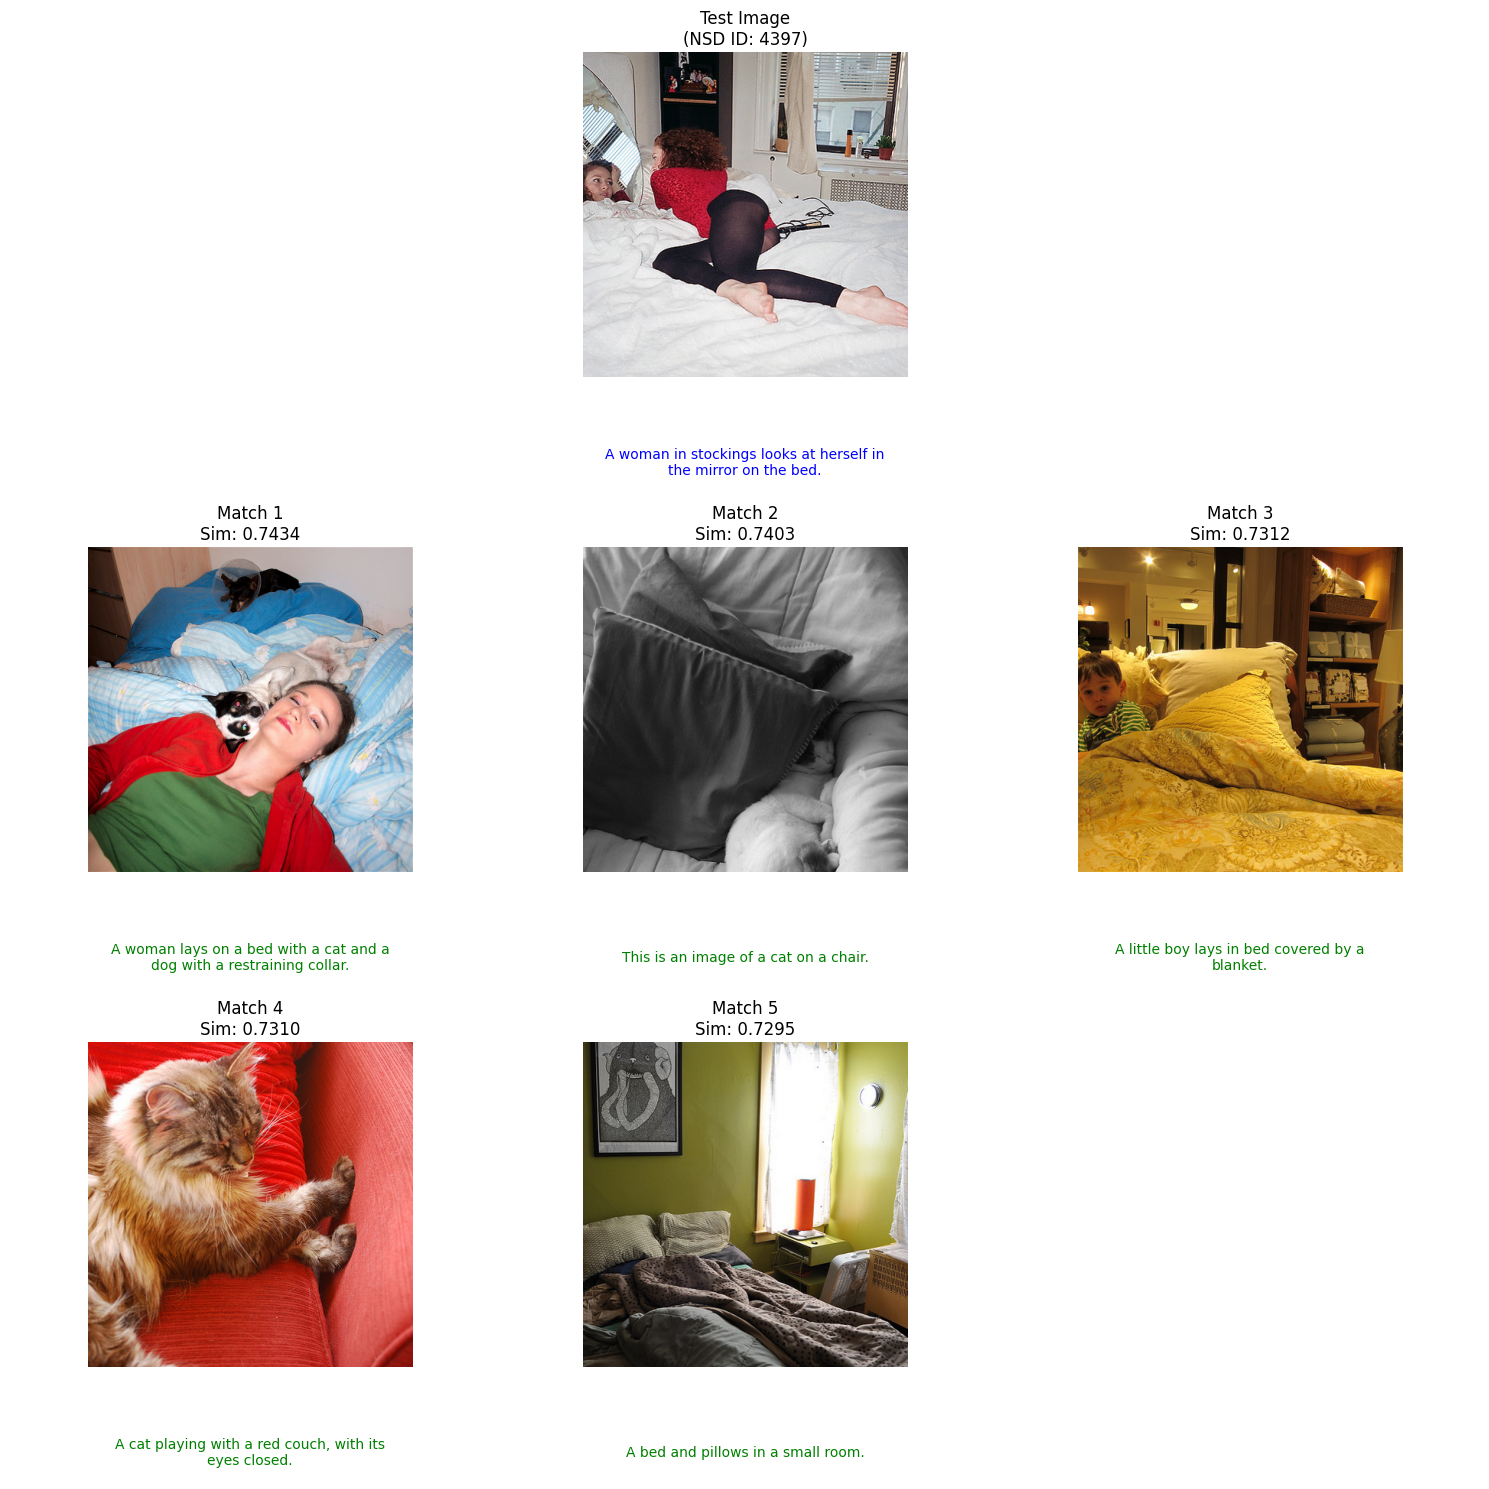

In [64]:
visualize_results(0, top_indices, top_similarities, test_info, train_info, stim_info)

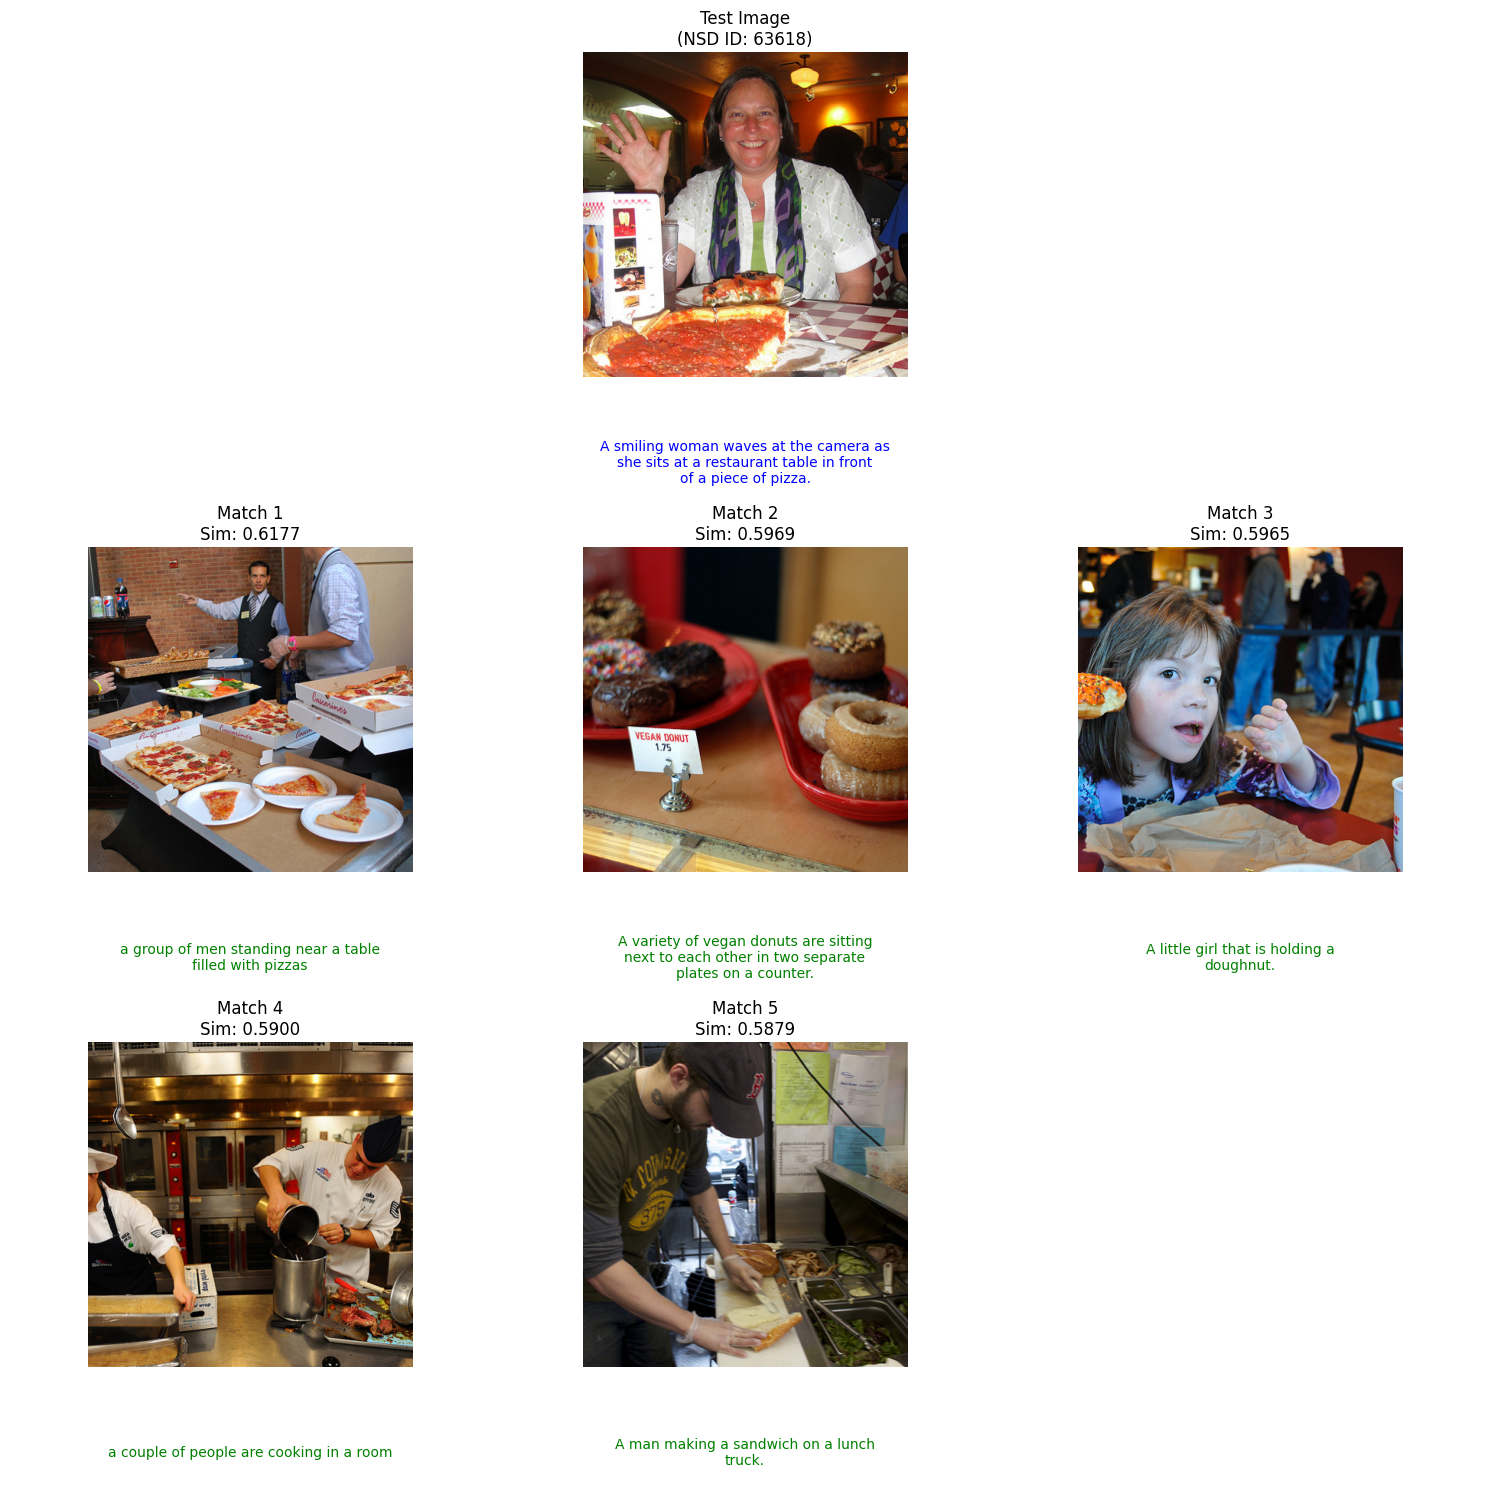

In [66]:
visualize_results(2, top_indices, top_similarities, test_info, train_info, stim_info)

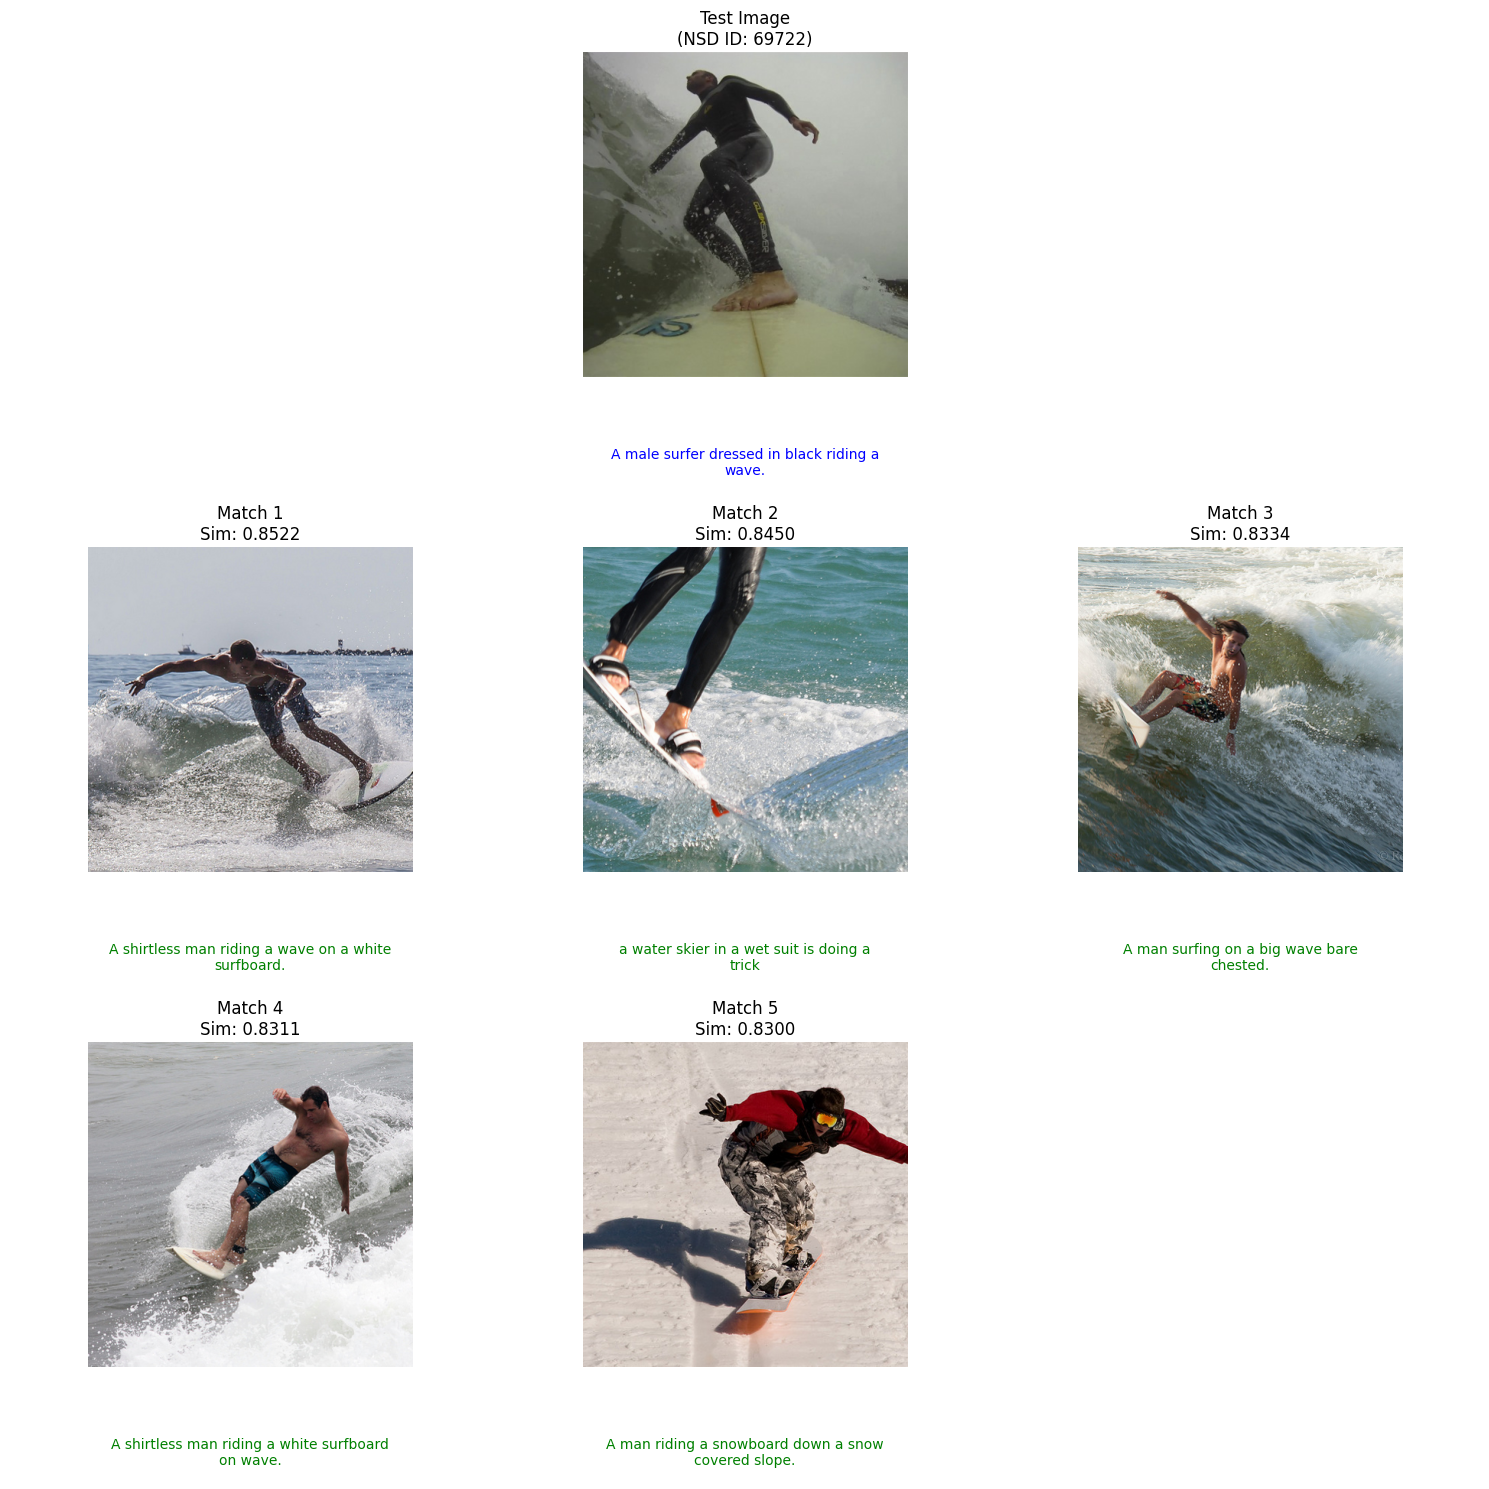

In [67]:
visualize_results(3, top_indices, top_similarities, test_info, train_info, stim_info)

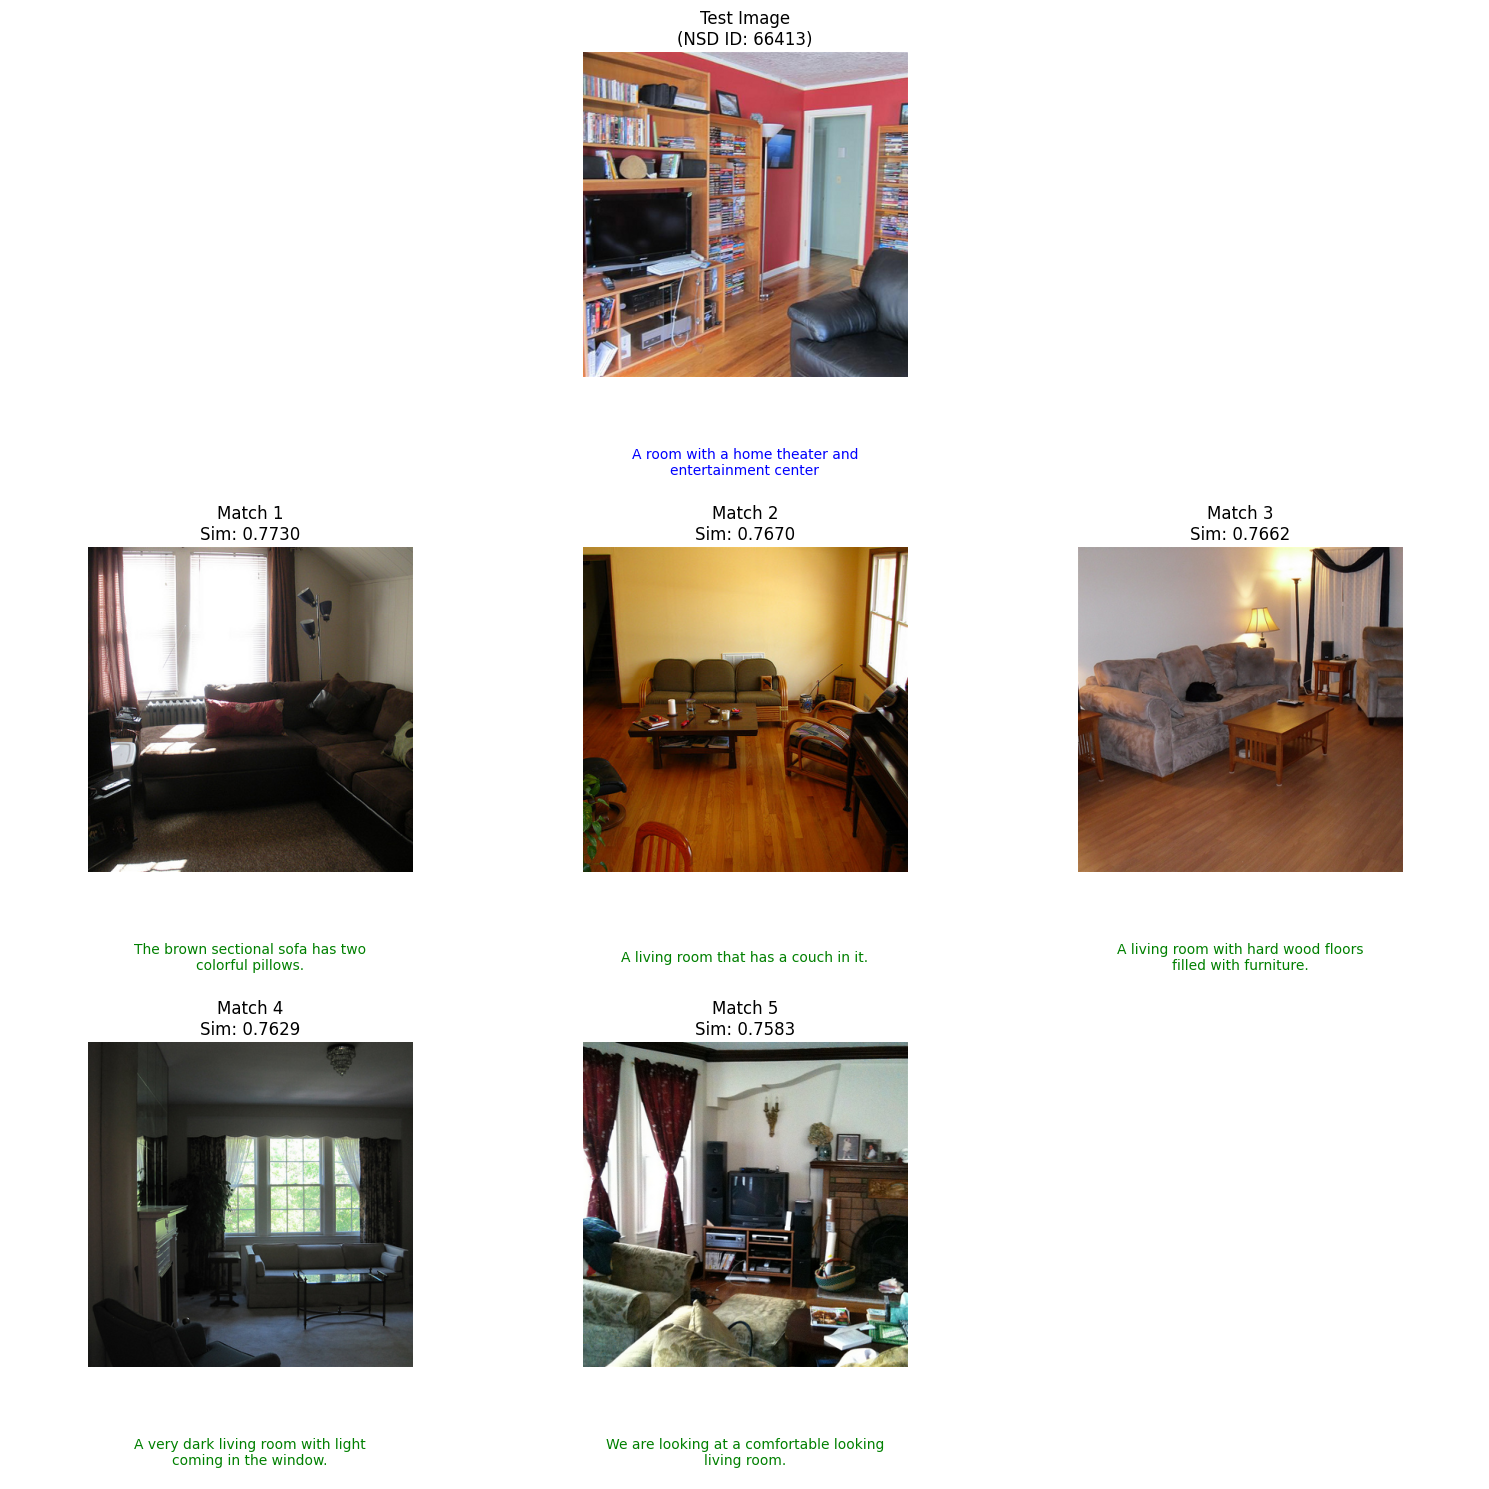

In [68]:
visualize_results(4, top_indices, top_similarities, test_info, train_info, stim_info)